- 1. 训练

使用正弦函数和一些可加性噪声来生成序列数据， 时间步为 1，2，3，。。。1000

Using matplotlib backend: module://matplotlib_inline.backend_inline


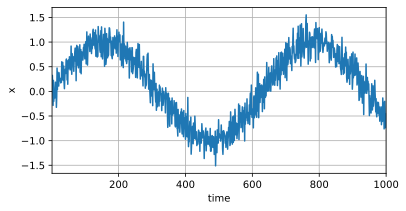

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

%matplotlib
import torch
from d2l import torch as d2l

T = 1000 # 时间步
time = torch.arange(1, T+1, dtype=torch.float32)
# print(time.shape)

# time 是一个一维向量，长度为 1000
# torch.sin(0.01 * time) 生成正弦函数
# torch.normal(0, 0.2, (T,)) 生成正态分布, 均值为 0，标准差为 0.2, 长度为 1000
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

d2l.plot(X=time, Y=x, xlabel='time', ylabel='x', xlim=[1, 1000], figsize=(6, 3))

- 用过去 τ 个时间步的观测值来预测下一个值

In [4]:
tau = 4
# 建立特征矩阵, [996, 4], 996 是时间步数减去τ, 4 是τ, 表示建立996个样本, 每个样本4个特征的数据集
features = torch.zeros((T-tau, tau))

'''
单步预测

将 x 数据集按照 tau=4 作为一组来预测下一个值, 比如:
x[0]、x[1]、x[2]、x[3] -> x[4]
x[1]、x[2]、x[3]、x[4] -> x[5]
...
x[995]、x[996]、x[997]、x[998] -> x[999]


x[996]、x[997]、x[998]、x[999] -> x[1000] # 实际这个值还没有, 需要根据前面的计算作为基准来预测
'''
# 特征矩阵填充测试数据,i=0时, x[0:996], ... i=3时, x[3:999], i 对应features的第i列
for i in range(tau):
    features[:, i] = x[i:T-tau+i]

labels = x[tau:].reshape(-1, 1) # 4 ~ 999 个数据

# print(features.shape)
# print(labels.shape)

batch_size, n_train  = 16, 600
# 前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, True)

In [5]:
from torch import nn

# 初始化网络权重的函数
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 定义一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weight)
    return net

# 定义损失函数, 注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss()

- 定义训练函数

In [6]:
def train(net, train_iter, loss, epochs, lr):
    # 定义优化函数, 用来更新权重、偏置相关参数
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.088365
epoch 2, loss: 0.052968
epoch 3, loss: 0.047503
epoch 4, loss: 0.049017
epoch 5, loss: 0.050432


- 预测

训练的时候只用了前600样本, 这里用所有样本做预测 <br>
单步预测（one-step-ahead prediction）, 检查模型预测下一个时间步的能力

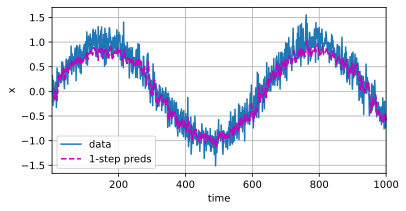

In [7]:
one_step_preds = net(features) # 根据真实值通过模型计算预测值

# tau=4, 因为 features 样本数是996, 所有第二个图x轴用 time[tau:]
d2l.plot(X=[time, time[tau:]], Y=[x.detach().numpy(), one_step_preds.detach().numpy()], xlabel='time', ylabel='x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

- k步预测

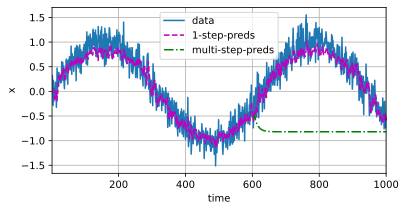

In [9]:
"""
上面相当于用前600个数据做训练
这里相当于用后面 604~999的数据做测试, 即下面绿色的线条
"""
multi_step_preds = torch.zeros(T)
multi_step_preds[: n_train + tau] = x[: n_train + tau]

# n_train=600, tau=4, 评估604 ~ 999 之间的样本
for i in range(n_train + tau, T):
    multi_step_preds[i] = net(multi_step_preds[i-tau:i].reshape(1, -1))

d2l.plot(X=[time, time[tau:], time[n_train + tau:]], Y=[x.detach().numpy(), one_step_preds.detach().numpy(), multi_step_preds[n_train + tau:].detach().numpy()], xlabel='time', ylabel='x', legend=['data', '1-step-preds', 'multi-step-preds'], xlim=[1, 1000], figsize=(6, 3))

- 基于 k=1, 4, 16, 64，通过对整个序列预测的计算， 让我们更仔细地看一下 k 步预测的困难

torch.Size([933, 68])


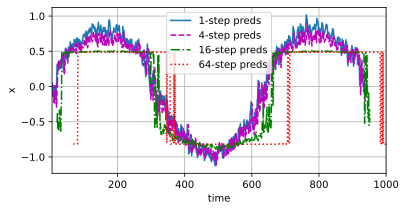

In [11]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1] # T - tau - max_steps + 1 保证 和 features 的行数一致

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i-tau:i]).reshape(-1)

print(features.shape)

steps = [1, 4, 16, 64]
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))